In [68]:
# =========================
# Import packages required
# =========================

import yfinance as yf
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns


In [69]:
md_tick = ["AAPL","MSFT","JPM","XOM"]

md_data = yf.download(md_tick,start="2020-01-01",end="2025-01-01")

md_data = md_data["Close"].reset_index()
md_data.head()


/var/folders/s0/0m6n4v4x6h3d3gzj70fr9gz00000gn/T/ipykernel_58299/2794052229.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  md_data = yf.download(md_tick,start="2020-01-01",end="2025-01-01")
[*********************100%***********************]  4 of 4 completed


Ticker,Date,AAPL,JPM,MSFT,XOM
0,2020-01-02,72.468269,119.573341,152.791092,53.661713
1,2020-01-03,71.763710,117.995422,150.888611,53.230301
2,2020-01-06,72.335548,117.901588,151.278625,53.639023
3,2020-01-07,71.995354,115.897224,149.899307,53.200024
4,2020-01-08,73.153503,116.801331,152.286926,52.397751


In [70]:
# Transfer the data to raw folder
md_rawpath = Path("/Users/baloyithabangbonganijunior/Library/CloudStorage/OneDrive-UniversityofCapeTown/ACADEMICS FOLDER/WORK PROJECTS/Advanced Quantitative Engineering & AI Portfolio/01-Finance/data/raw")

# Create folder if it does not exist
raw_path.mkdir(parents=True, exist_ok=True)

# Save the CSV filer inside the raw folder
md_filepath = md_rawpath/"banking_market_prices.csv"

md_data.to_csv(md_filepath,index=False)

file_path = Path("/Users/baloyithabangbonganijunior/Library/CloudStorage/OneDrive-UniversityofCapeTown/ACADEMICS FOLDER/WORK PROJECTS/Advanced Quantitative Engineering & AI Portfolio/01-Finance/data/raw/banking_market_prices.csv")

prices = pd.read_csv(file_path, parse_dates=["Date"])
prices.set_index("Date", inplace=True)



In [71]:
# Compute daily log returns
log_return = np.log(prices/prices.shift(1)).dropna()
log_return.head()

# Compute risk metrics

#Volatility
vol_annual = log_return.std()*np.sqrt(252)
vol_annual.head()

# Correlation matrix
corr = log_return.corr()
corr.head()

,AAPL,JPM,MSFT,XOM
AAPL,1.000000,0.414320,0.750913,0.288140
JPM,0.414320,1.000000,0.424329,0.572315
MSFT,0.750913,0.424329,1.000000,0.248585
XOM,0.288140,0.572315,0.248585,1.000000


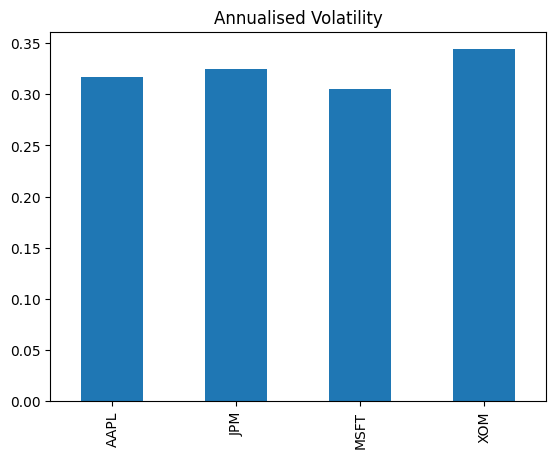

In [72]:
vol_annual.plot(kind="bar", title="Annualised Volatility")
plt.show()

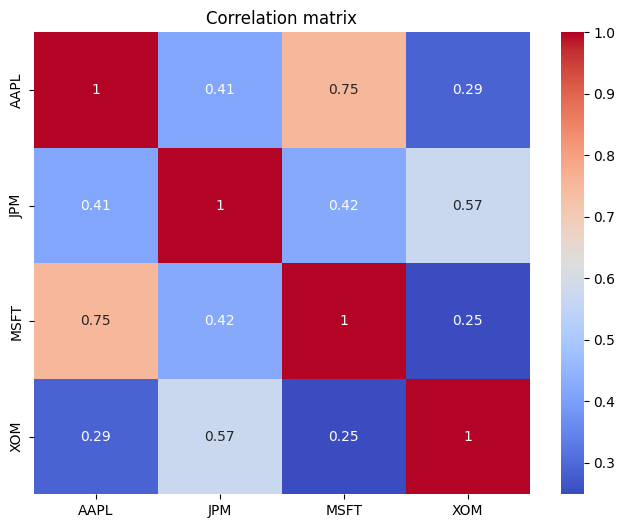

In [73]:
plt.figure(figsize=(8,6))
sns.heatmap(corr,annot= True,cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

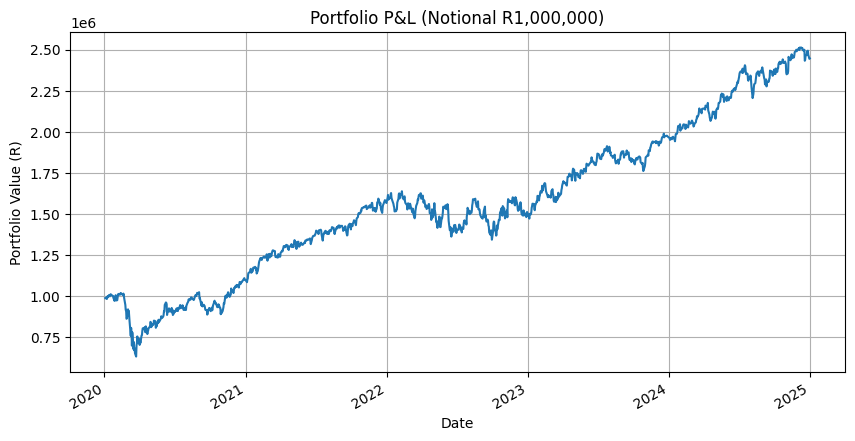

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define portfolio weights (equal weight example)
weights = pd.Series(
    {
        "AAPL": 0.25,
        "MSFT": 0.25,
        "JPM": 0.25,
        "XOM": 0.25,
    }
)

# Make sure weights match columns in log_returns
weights = weights.reindex(log_return.columns).fillna(0)

# 2. Compute daily portfolio log return
port_log_ret = (log_return * weights).sum(axis=1)

# 3. Convert to cumulative P&L for a notional portfolio (e.g. R1,000,000)
initial_value = 1_000_000
cum_factor = np.exp(port_log_ret.cumsum())     # since they are log returns
portfolio_value = initial_value * cum_factor

# 4. Plot portfolio P&L over time
plt.figure(figsize=(10, 5))
portfolio_value.plot()
plt.title("Portfolio P&L (Notional R1,000,000)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (R)")
plt.grid(True)
plt.show()


1-day VaR 95%: 2.0989%
1-day VaR 99%: 4.1843%


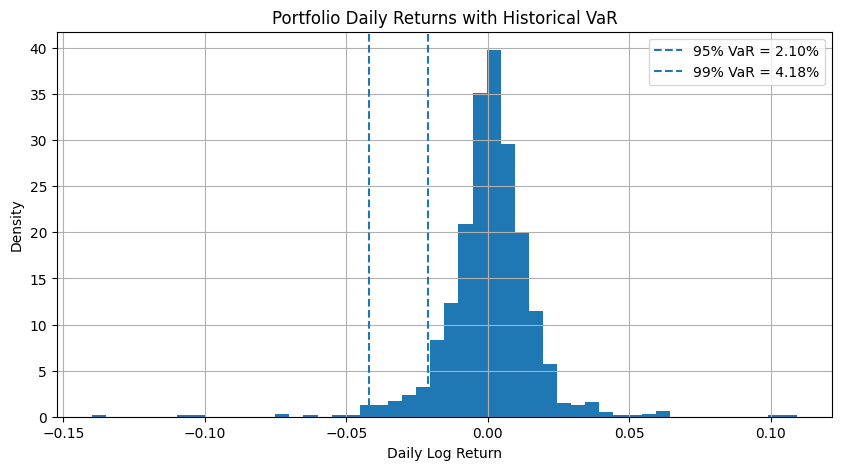

In [75]:
# 1. Compute historical VaR (one-day horizon)
alpha_95 = 0.95
alpha_99 = 0.99

# Note: portfolio returns are log, but for small moves they’re close to simple returns
var_95 = -np.percentile(port_log_ret, (1 - alpha_95)*100)
var_99 = -np.percentile(port_log_ret, (1 - alpha_99)*100)

print(f"1-day VaR 95%: {var_95:.4%}")
print(f"1-day VaR 99%: {var_99:.4%}")

plt.figure(figsize=(10, 5))

# Histogram of portfolio daily log returns
plt.hist(port_log_ret, bins=50, density=True)
plt.title("Portfolio Daily Returns with Historical VaR")
plt.xlabel("Daily Log Return")
plt.ylabel("Density")

# VaR cutoffs as vertical lines
plt.axvline(-var_95, linestyle="--", label=f"95% VaR = {var_95:.2%}")
plt.axvline(-var_99, linestyle="--", label=f"99% VaR = {var_99:.2%}")

plt.legend()
plt.grid(True)
plt.show()


In [77]:
import sqlite3
from pathlib import Path

# Path to your SQLite DB (processed data)
db_path = Path("/Users/baloyithabangbonganijunior/Library/CloudStorage/OneDrive-UniversityofCapeTown/ACADEMICS FOLDER/WORK PROJECTS/Advanced Quantitative Engineering & AI Portfolio/01-Finance/data/processed/banking_risk.db")
db_path.parent.mkdir(parents=True, exist_ok=True)

conn = sqlite3.connect(db_path)

# Save prices
prices.to_sql("prices", conn, if_exists="replace", index_label="date")

# Save log returns
log_return.to_sql("log_return", conn, if_exists="replace", index_label="date")

# Save portfolio metrics in a tidy table
risk_metrics = pd.DataFrame(
    {
        "metric": ["var_95", "var_99"],
        "value": [float(var_95), float(var_99)],
    }
)
risk_metrics.to_sql("portfolio_risk", conn, if_exists="replace", index=False)

conn.close()
